# Emotion Analysis

Using pyTorch

In [0]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [0]:
# For data processing and maths
import numpy as np
import pandas as pd
import time
#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [0]:
# for ML tasks and text preprocessing

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import itertools
import pandas as pd
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [0]:
# import torch 
import torch
import torch.nn as nn

In [0]:
import pickle

def convert_to_pickle(item, directory):
    pickle.dump(item, open(directory,"wb"))


def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

In [6]:
! pip install version_information

In [7]:
# first install: pip install version_information
%reload_ext version_information
%version_information pandas,torch,numpy,seaborn, matplotlib

Software versions
Python 3.6.8 64bit [GCC 8.0.1 20180414 (experimental) [trunk revision 259383]
IPython 5.5.0
OS Linux 4.14.137+ x86_64 with Ubuntu 18.04 bionic
pandas 0.24.2
torch 1.2.0
numpy 1.16.5
seaborn 0.9.0
matplotlib 3.0.3
Fri Oct 18 16:27:50 2019 UTC

# 2)- Loading data

Thanks to PyCon 2019 : https://github.com/omarsar/nlp_pycon

In [0]:
data=pd.read_pickle('merged_training.pkl')

In [9]:
data.shape

(416809, 2)

In [10]:
data.head()

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love


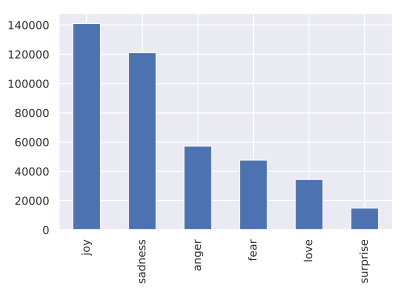

In [11]:
data.emotions.value_counts().plot(kind='bar')

# 3)-Preprocessing

- a)- Tokenize
- b)-Sampling
- c)-Vocab Building
- d)- Tensor Conversion
- e)-Padding

### a)-tokenize

In [0]:
data['token']=data['text'].apply(lambda x:x.split(' '))

In [13]:
data.head()

,text,emotions,token
27383,i feel awful about it too because it s my job ...,sadness,"[i, feel, awful, about, it, too, because, it, ..."
110083,im alone i feel awful,sadness,"[im, alone, i, feel, awful]"
140764,ive probably mentioned this before but i reall...,joy,"[ive, probably, mentioned, this, before, but, ..."
100071,i was feeling a little low few days back,sadness,"[i, was, feeling, a, little, low, few, days, b..."
2837,i beleive that i am much more sensitive to oth...,love,"[i, beleive, that, i, am, much, more, sensitiv..."


In [14]:
data["token_size"] = data["text"].apply(lambda x: len(x.split(' ')))
data.head()

,text,emotions,token,token_size
27383,i feel awful about it too because it s my job ...,sadness,"[i, feel, awful, about, it, too, because, it, ...",26
110083,im alone i feel awful,sadness,"[im, alone, i, feel, awful]",5
140764,ive probably mentioned this before but i reall...,joy,"[ive, probably, mentioned, this, before, but, ...",27
100071,i was feeling a little low few days back,sadness,"[i, was, feeling, a, little, low, few, days, b...",9
2837,i beleive that i am much more sensitive to oth...,love,"[i, beleive, that, i, am, much, more, sensitiv...",18


In [15]:
data.shape

(416809, 4)

In [0]:
# Limiting size to avoid too much padding
data = data.loc[data['token_size'] < 70].copy()

In [17]:
data.shape

(416789, 4)

Notice how we have reduced our samples as we are only taking token size < 70

### b)- sampling

In [18]:
data = data.sample(n=50000);

data.head()

,text,emotions,token,token_size
13806,im down but aside from that it feels very stra...,surprise,"[im, down, but, aside, from, that, it, feels, ...",13
30552,i love our winter sits by the fire dreaming up...,fear,"[i, love, our, winter, sits, by, the, fire, dr...",25
9545,i am trying to redirect myself in the fact i f...,sadness,"[i, am, trying, to, redirect, myself, in, the,...",20
5390,i am learning to take inventory of my feelings...,anger,"[i, am, learning, to, take, inventory, of, my,...",30
76938,i knew it was stupid but the night terrors kep...,sadness,"[i, knew, it, was, stupid, but, the, night, te...",44


We could also use shuffle to do randomly select our sample. This random selection will reduce possibility of selection biasness in our data.

### c)- Vocab building

After tokenizing text, it's time to build the vocabulary, which is used to determine the features that we will be using to train the models.

In [0]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for the dataset
class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word  

In [0]:
# construct vocab and indexing
inputs = ConstructVocab(data["text"].values.tolist())

In [21]:
type(inputs)

__main__.ConstructVocab

In [22]:
# examples of what is in the vocab
inputs.vocab[0:10]

['a',
 'aa',
 'aaa',
 'aaaa',
 'aaaahhhhhh',
 'aaah',
 'aaargh',
 'aab',
 'aahhh',
 'aallll']

### d)-Converting Data Into Tensors

In [0]:
# vectorize to tensor
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in data["text"].values.tolist()]

In [24]:
# examples of what is in the input tensors
input_tensor[0:2]

[[11750,
  7024,
  3259,
  1332,
  9539,
  24305,
  12648,
  8743,
  26128,
  23267,
  24679,
  1978,
  11679],
 [11622,
  14282,
  16989,
  26914,
  22031,
  3286,
  24314,
  8956,
  7115,
  25825,
  26692,
  26649,
  6863,
  26714,
  26914,
  12607,
  17054,
  3259,
  12680,
  4544,
  24679,
  8727,
  1,
  14073,
  23746]]

In [25]:
type(input_tensor)

list

### e)-Padding Data
In order to train our recurrent neural network , it is required padding to generate inputs of same length.

In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [27]:
# calculate the max_length of input tensor
max_length_inp = max_length(input_tensor)
print(max_length_inp)

66


In [0]:
import numpy as np

def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
    return padded

In [0]:
# inplace padding
input_tensor = [pad_sequences(x, max_length_inp) for x in input_tensor]

In [30]:
input_tensor[0:2]

[array([11750,  7024,  3259,  1332,  9539, 24305, 12648,  8743, 26128,
        23267, 24679,  1978, 11679,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0]),
 array([11622, 14282, 16989, 26914, 22031,  3286, 24314,  8956,  7115,
        25825, 26692, 26649,  6863, 26714, 26914, 12607, 17054,  3259,
        12680,  4544, 24679,  8727,     1, 14073, 23746,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,    

All these extra zero are making matrix of our interest as of same length. Hence, padding is important before modeling.

**Our input is ready for model. But, we need to look at target feature as well**

# 4)- Target Variable

In [31]:
data.emotions.value_counts()

joy         17066
sadness     14428
anger        6998
fear         5678
love         4072
surprise     1758
Name: emotions, dtype: int64

In [0]:
# convert targets to one-hot encoding vectors
emotions = list(set(data.emotions.unique()))
num_emotions = len(emotions)

In [33]:
emotions

['fear', 'sadness', 'joy', 'love', 'anger', 'surprise']

In [34]:
num_emotions

6

In [0]:
# binarizer
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(emos) & set(emotions) for emos in data[['emotions']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_emotions.tolist())

In [36]:
target_tensor

array([[0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]])

In [0]:
get_emotion = lambda t: np.argmax(t)

In [38]:
get_emotion(target_tensor[0])

5

In [0]:
emotion_dict = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}

In [40]:
emotion_dict[get_emotion(target_tensor[0])]

'surprise'

### 4.2)- Splitting data into train and validation set

In [41]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

(40000, 40000, 5000, 5000, 5000, 5000)

### 4.3)-Dataset and Data Loader
We can also laod the data into a data loader, which makes it easy to manipulate the data, create batches, and apply further transformations. In PyTorch we can use the DataLoader function.

In [0]:
TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64

TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

In [0]:
from torch.utils.data import Dataset, DataLoader

In [0]:
class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]
        return x, y, x_len
    
    def __len__(self):
        return len(self.data)

In [0]:
# Data instance
train_dataset = MyData(input_tensor_train, target_tensor_train)
val_dataset = MyData(input_tensor_val, target_tensor_val)
test_dataset = MyData(input_tensor_test, target_tensor_test)


# Data Loader instance
train_dataset = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

val_dataset = DataLoader(val_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

test_dataset = DataLoader(test_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

In [46]:
train_dataset.dataset.data[:2]

[array([11622,   756, 13070,  8740, 22399, 10164, 20432, 16455,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0]),
 array([11622,  8727, 23418, 11622, 26862,  1978,  9357, 16993, 11622,
         8727,  5154,   866, 11622,  3412, 11760, 24314, 10474,  4544,
         3865, 12457, 15885, 11107, 18048,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,    

We have all tensors given in train_dataset

In [47]:
val_dataset.batch_size

64

In [48]:
train_dataset.batch_size

64

In [49]:
test_dataset.batch_size

64

### 4.4)-Store the Data for Reuse

In [0]:
data_folder = "Data"
convert_to_pickle(train_dataset, data_folder + "train_dataset")
convert_to_pickle(val_dataset, data_folder + "val_dataset")
convert_to_pickle(test_dataset, data_folder + "test_dataset")

In [0]:
# Helper functions
import pickle

def convert_to_pickle(item, directory):
    pickle.dump(item, open(directory,"wb"))


def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

# 5)- Model 

- Using GRU

In [0]:
class EmoGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoGRU, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.output_size = output_size
        
        # layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_units)
        self.fc = nn.Linear(self.hidden_units, self.output_size)
    
    def initialize_hidden_state(self, device):
        return torch.zeros((1, self.batch_sz, self.hidden_units)).to(device)
    
    def forward(self, x, lens, device):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state(device)
        output, self.hidden = self.gru(x, self.hidden) # max_len X batch_size X hidden_units
        out = output[-1, :, :] 
        out = self.dropout(out)
        out = self.fc(out)
        return out, self.hidden

### 5.1)-Pretesting models

In [53]:
len(inputs.word2idx)

27477

In [54]:
num_emotions

6

In [0]:
# parameters
TRAIN_BUFFER_SIZE = 40000 # len(input_tensor_train)
VAL_BUFFER_SIZE = 5000 # len(input_tensor_val)
TEST_BUFFER_SIZE = 5000 # len(input_tensor_test)
BATCH_SIZE = 64
TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = 27477 # len(inputs.word2idx)
target_size = 6 # num_emotions

In [0]:
# sort batch function to be able to use with pad_packed_sequence
# batch elements ordered decreasingle by their length

def sort_batch(X, y, lengths):
    "sort the batch by length"
    
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X.transpose(0,1), y, lengths # transpose (batch x seq) to (seq x batch)

### 5.3)-Setup machine

In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

# obtain one sample from the data iterator
it = iter(train_dataset)
x, y, x_len = next(it)

# sort the batch first to be able to use with pac_pack sequence
xs, ys, lens = sort_batch(x, y, x_len)

print("Input size: ", xs.size())

output, _ = model(xs.to(device), lens, device)
print(output.size())

Input size:  torch.Size([66, 64])
torch.Size([64, 6])


- 66 is actually our max_length of input tensor
-  64 is size of batch
- 6 is target output i.e we have 6 number of emotions

### 5.3)- Setup for training

In [0]:
# Enabling cuda
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

# loss criterion and optimizer for training
criterion = nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss
optimizer = torch.optim.Adam(model.parameters())

def loss_function(y, prediction):
    """ CrossEntropyLoss expects outputs and class indices as target """
    # convert from one-hot encoding to class indices
    target = torch.max(y, 1)[1]
    loss = criterion(prediction, target) 
    return loss   #TODO: refer the parameter of these functions as the same
    
def accuracy(target, logit):
    ''' Obtain accuracy for training round '''
    target = torch.max(target, 1)[1] # convert from one-hot encoding to class indices
    corrects = (torch.max(logit, 1)[1].data == target).sum()
    accuracy = 100.0 * corrects / len(logit)
    return accuracy

### 6)- Train the model

In [61]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    ### Initialize hidden state
    # TODO: do initialization here.
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0
    
    ### Training
    for (batch, (inp, targ, lens)) in enumerate(train_dataset):
        loss = 0
        predictions, _ = model(inp.permute(1 ,0).to(device), lens, device) # TODO:don't need _   
              
        loss += loss_function(targ.to(device), predictions)
        batch_loss = (loss / int(targ.shape[1]))        
        total_loss += batch_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_accuracy = accuracy(targ.to(device), predictions)
        train_accuracy += batch_accuracy
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Val. Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.cpu().detach().numpy()))
            
    ### Validating
    for (batch, (inp, targ, lens)) in enumerate(val_dataset):        
        predictions,_ = model(inp.permute(1, 0).to(device), lens, device)        
        batch_accuracy = accuracy(targ.to(device), predictions)
        val_accuracy += batch_accuracy
    
    print('Epoch {} Loss {:.4f} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1, 
                                                             total_loss / TRAIN_N_BATCH, 
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / VAL_N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Val. Loss 0.3147
Epoch 1 Batch 100 Val. Loss 0.2677
Epoch 1 Batch 200 Val. Loss 0.2243
Epoch 1 Batch 300 Val. Loss 0.1079
Epoch 1 Batch 400 Val. Loss 0.0658
Epoch 1 Batch 500 Val. Loss 0.0582
Epoch 1 Batch 600 Val. Loss 0.0526
Epoch 1 Loss 0.1427 -- Train Acc. 66.0000 -- Val Acc. 91.0000
Time taken for 1 epoch 56.097636222839355 sec

Epoch 2 Batch 0 Val. Loss 0.0347
Epoch 2 Batch 100 Val. Loss 0.0267
Epoch 2 Batch 200 Val. Loss 0.0137
Epoch 2 Batch 300 Val. Loss 0.0189
Epoch 2 Batch 400 Val. Loss 0.0182
Epoch 2 Batch 500 Val. Loss 0.0133
Epoch 2 Batch 600 Val. Loss 0.0103
Epoch 2 Loss 0.0263 -- Train Acc. 92.0000 -- Val Acc. 92.0000
Time taken for 1 epoch 55.84689283370972 sec

Epoch 3 Batch 0 Val. Loss 0.0146
Epoch 3 Batch 100 Val. Loss 0.0078
Epoch 3 Batch 200 Val. Loss 0.0088
Epoch 3 Batch 300 Val. Loss 0.0109
Epoch 3 Batch 400 Val. Loss 0.0090
Epoch 3 Batch 500 Val. Loss 0.0319
Epoch 3 Batch 600 Val. Loss 0.0180
Epoch 3 Loss 0.0196 -- Train Acc. 93.0000 -- Val Acc. 

### save model

In [0]:
torch.save(model, "emotion.h")

# 7)- Model Evaluation

In [0]:
model = torch.load('emotion.h')

In [64]:
test_accuracy = 0
all_predictions = []
x_raw = []
y_raw = []

#device = "cuda" # we don't need GPU to do testing
#model.to("cuda")

for (batch, (inp, targ, lens)) in enumerate(test_dataset):          
    predictions,_ = model(inp.permute(1, 0).to(device), lens, device)        
    batch_accuracy = accuracy(targ.to(device), predictions)
    test_accuracy += batch_accuracy
    
    x_raw = x_raw + [x for x in inp]
    y_raw = y_raw + [y for y in targ]
    
    all_predictions.append(predictions)
    
print("Test Accuracy: ", test_accuracy.cpu().detach().numpy() / TEST_N_BATCH)

Test Accuracy:  92.73076923076923


### Confusion Matrix

In [0]:
import itertools

In [0]:

# Class to Evaluate our model with other metrics
class Evaluate():

    def evaluate_class(cls, predictions, target, target2=None, silent=False):
        """ Compute only the predicted class """
        p_2_annotation = dict()

        precision_recall_fscore_support = [
            (pair[0], pair[1].mean()) for pair in zip(
                ['precision', 'recall', 'f1', 'support'],
                metrics.precision_recall_fscore_support(target, predictions)
            )
        ]

        metrics.precision_recall_fscore_support(target, predictions)

        # confusion matrix
        le = LabelEncoder()
        target_le = le.fit_transform(target)
        predictions_le = le.transform(predictions)
        cm = metrics.confusion_matrix(target_le, predictions_le)

        # prediction if two annotations are given on test data
        if target2:
            p_2_annotation = pd.DataFrame(
                [(pred, pred in set([t1,t2])) for pred, t1, t2 in zip(predictions, target, target2)],
                columns=['emo','success']
            ).groupby('emo').apply(lambda emo: emo.success.sum()/ len(emo.success)).to_dict()

        if not silent:
            print("Default Classification report")
            print(metrics.classification_report(target, predictions))

            # print if target2 was provided
            if len(p_2_annotation) > 0:
                print('\nPrecision on 2 annotations:')
                for emo in p_2_annotation:
                    print("%s: %.2f" % (emo, p_2_annotation[emo]))

            # print accuracies, precision, recall, and f1
            print('\nAccuracy:')
            print(metrics.accuracy_score(target, predictions))
            print("Correct Predictions: ", metrics.accuracy_score(target, predictions,normalize=False))
            for to_print in precision_recall_fscore_support[:3]:
                print( "%s: %.2f" % to_print )

            # normalizing the values of the consfusion matrix
            print('\nconfusion matrix\n %s' % cm)
            print('(row=expected, col=predicted)')
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            cls.plot_confusion_matrix(cm_normalized, le.classes_, 'Confusion matrix Normalized')

        return {
            'precision_recall_fscore_support': precision_recall_fscore_support,
            'accuracy': metrics.accuracy_score(target, predictions),
            'p_2_annotation': p_2_annotation,
            'confusion_matrix': cm
        }

    def plot_confusion_matrix(cls, cm, my_tags, title='Confusion matrix', cmap=plt.cm.Blues):
        """ Plotting the confusion_matrix"""
        plt.rc('figure', figsize=(4, 4), dpi=100)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(my_tags))
        target_names = my_tags
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        
        # add normalized values inside the Confusion matrix
        fmt = '.2f'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

Default Classification report
              precision    recall  f1-score   support

       anger       0.97      0.91      0.94       655
        fear       0.88      0.94      0.91       581
         joy       0.95      0.95      0.95      1710
        love       0.82      0.85      0.84       422
     sadness       0.96      0.98      0.97      1430
    surprise       0.88      0.73      0.80       194

    accuracy                           0.93      4992
   macro avg       0.91      0.89      0.90      4992
weighted avg       0.93      0.93      0.93      4992


Accuracy:
0.9324919871794872
Correct Predictions:  4655
precision: 0.91
recall: 0.89
f1: 0.90

confusion matrix
 [[ 593   16    5    2   39    0]
 [   8  544    4    0   12   13]
 [   1    2 1620   77    4    6]
 [   0    0   60  360    2    0]
 [  11   17    5    0 1397    0]
 [   0   39   13    0    1  141]]
(row=expected, col=predicted)


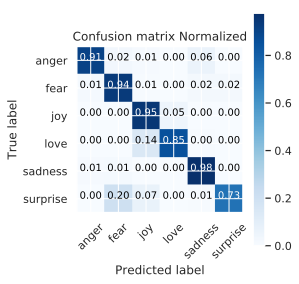

In [67]:
evaluator = Evaluate()

final_predictions = []

for p in all_predictions:
    for sub_p in p:
        final_predictions.append(sub_p.cpu().detach().numpy())
        
predictions = [np.argmax(p).item() for p in final_predictions]
targets = [np.argmax(t).item() for t in y_raw]
correct_predictions = float(np.sum(predictions == targets))

# predictions
predictions_human_readable = ((x_raw, predictions))
# actual targets
target_human_readable = ((x_raw,  targets))

emotion_dict = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}

# convert results into dataframe
model_test_result = pd.DataFrame(predictions_human_readable[1],columns=["emotion"])
test = pd.DataFrame(target_human_readable[1], columns=["emotion"])

model_test_result.emotion = model_test_result.emotion.map(lambda x: emotion_dict[int(float(x))])
test.emotion = test.emotion.map(lambda x: emotion_dict[int(x)])

evaluator.evaluate_class(model_test_result.emotion, test.emotion );